In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math

# This is to show multiple outputs in 1 cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# This function compiles weekly data from a given season based on scoring format
def getYearlyStatsFP(season, scoring='STD'):
    
    # Based on the scoring input ('STD' by default), this modifies the url.
    if scoring == 'HALF':
        scoring_param = 'half-ppr.php'
    elif scoring == 'PPR':
        scoring_param = 'ppr.php'
    else:
        scoring_param = ''
    
    # Create an empty DataFrame to append each week to.
    df = pd.DataFrame()
    
    for week in range(1,18):
    
        url = "https://www.fantasypros.com/nfl/reports/leaders/{}?year={}&start={}&end={}".format(scoring_param,
                                                                                                  season,
                                                                                                  week,
                                                                                                  week)

        df1 = pd.read_html(url)[0]

        df1['Week'] = week
        
        df1 = df1[['Week','Player','Position','Team','Points']]
        
        df = df.append(df1, ignore_index=True)
    
    # Create a .csv from the output
    filename = "{}_FP_{}".format(season, scoring)
    df.to_csv(filename)
    
    return df

In [3]:
df = getYearlyStatsFP(2019,'HALF')
df.head()

,Week,Player,Position,Team,Points
0,1,Sammy Watkins,WR,KC,42.3
1,1,Christian McCaffrey,RB,CAR,37.9
2,1,Austin Ekeler,RB,LAC,36.4
3,1,Lamar Jackson,QB,BAL,33.6
4,1,Dak Prescott,QB,DAL,33.4


In [4]:
# This function creates scoring range based on 
def playerConf(conf,week):
    
    alpha = 1-conf
    
    summary = df[df['Week']<week][['Player',
                                   'Position',
                                   'Team',
                                   'Points']].groupby(by=['Player',
                                                          'Position',
                                                          'Team']).agg(['sum',
                                                                        'mean',
                                                                        'std',
                                                                        'count'])
    for i,player in summary.iterrows():
        
        # Calculate t value from alpha and degrees of freedom (n-1)
        n = player[('Points','count')]
        t = abs(st.t.ppf(alpha/2,df = n-1))
        std = player[('Points','std')]
    
        
        summary.loc[i,'low'] = player[('Points','mean')] - (t * (std/math.sqrt(n)))
        summary.loc[i,'high'] = player[('Points','mean')] + (t * (std/math.sqrt(n)))
        
    summary['range'] = summary['high'] - summary['low']
        
    summary.dropna(inplace=True)
    summary.sort_values(by=('Points','sum'),ascending=False,inplace=True)
    summary.reset_index(inplace=True)
        
    return summary

In [5]:
summary = playerConf(.90,15)
summary.head()

Player Position Team Points                              \
                                        sum       mean        std count   
0        Lamar Jackson       QB  BAL  354.8  27.292308   6.454903    13   
1  Christian McCaffrey       RB  CAR  335.6  25.815385  10.224549    13   
2       Deshaun Watson       QB  HOU  303.5  23.346154  10.048019    13   
3         Dak Prescott       QB  DAL  290.3  22.330769   7.777359    13   
4       Russell Wilson       QB  SEA  283.0  21.769231  10.132899    13   

         low       high      range  
                                    
0  24.101535  30.483080   6.381544  
1  20.761210  30.869560  10.108350  
2  18.379241  28.313067   9.933826  
3  18.486284  26.175255   7.688971  
4  16.760360  26.778101  10.017741

In [6]:
print('\033[1;4m'+'The Top 10 Most Consistent/Predictable Players by Position:')
print('\033[0m')

for pos in ['QB','RB','WR','TE','DST']:
    
    if pos == 'QB':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(20)
        
    elif pos == 'TE':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(30)
        
    elif (pos == 'WR') | (pos == 'RB'):
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(50)
        
    else:
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False)
    
    df_temp = df_temp.sort_values(by='range', ascending=True).head(10)

    print(pos)
    print(df_temp[['Player','low','high']])
    print('')

# -----------------------------------------------------------------------------------------------------------------

print('\033[1;4m'+'The Top 10 Most Unpredictable Players by Position:')
print('\033[0m')

for pos in ['QB','RB','WR','TE','DST']:
    
    if pos == 'QB':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(20)
        
    elif pos == 'TE':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(30)
        
    elif (pos == 'WR') | (pos == 'RB'):
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(50)
        
    else:
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False)
    
    df_temp = df_temp.sort_values(by='range', ascending=False).head(10)

    print(pos)
    print(df_temp[['Player','low','high']])
    print('')
    
# -----------------------------------------------------------------------------------------------------------------

print('\033[1;4m'+'The Top 10 Floors by Position:')
print('\033[0m')

for pos in ['QB','RB','WR','TE','DST']:
    
    if pos == 'QB':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(20)
        
    elif pos == 'TE':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(30)
        
    elif (pos == 'WR') | (pos == 'RB'):
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(50)
        
    else:
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False)
    
    df_temp = df_temp.sort_values(by='low', ascending=False).head(10)

    print(pos)
    print(df_temp[['Player','low','high']])
    print('')
    
# -----------------------------------------------------------------------------------------------------------------

print('\033[1;4m'+'The Bottom 10 Floors by Position:')
print('\033[0m')

for pos in ['QB','RB','WR','TE','DST']:
    
    if pos == 'QB':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(20)
        
    elif pos == 'TE':
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(30)
        
    elif (pos == 'WR') | (pos == 'RB'):
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False).head(50)
        
    else:
        
        df_temp = summary[(summary['Position'] == pos)].sort_values(by=('Points','sum'), ascending=False)
    
    df_temp = df_temp.sort_values(by='low', ascending=True).head(10)

    print(pos)
    print(df_temp[['Player','low','high']])
    print('')

The Top 10 Most Consistent/Predictable Players by Position:

QB
             Player        low       high
                                         
30       Derek Carr  12.408843  17.606542
18     Carson Wentz  14.564696  20.096842
22    Philip Rivers  13.793099  19.329977
7        Josh Allen  17.044406  22.847902
0     Lamar Jackson  24.101535  30.483080
31   Baker Mayfield  11.720851  18.140688
15     Kirk Cousins  14.357616  20.996230
8      Kyler Murray  15.927441  22.872559
29  Jacoby Brissett  12.878008  19.871992
17        Tom Brady  13.819166  20.903911

RB
                 Player        low       high
                                             
215        Nyheim Hines   4.145487   7.162206
154         Tarik Cohen   5.640982   9.235941
135       Royce Freeman   6.200320   9.876603
101         Carlos Hyde   7.261227  11.246465
234         Gus Edwards   2.959735   7.209496
71         Le'Veon Bell  10.284499  14.832167
21      Ezekiel Elliott  14.384744  19.061410
112        Duk

In [7]:
# FF Data Pros 2019

df2019 = pd.read_csv('2019_Weeks_1-17.csv',index_col=0)[['player_name','position','team','week']]

fp_abbvs = df2019['team'].sort_values().unique()
ffdp_abbvs = df['Team'].sort_values().unique()

In [8]:
abbv_dict = {'ARI':'ARI', 
             'ATL':'ATL', 
             'BAL':'BAL', 
             'BUF':'BUF', 
             'CAR':'CAR', 
             'CHI':'CHI', 
             'CIN':'CIN', 
             'CLE':'CLE', 
             'DAL':'DAL',
             'DEN':'DEN', 
             'DET':'DET',
             'GNB':'GB', 
             'HOU':'HOU', 
             'IND':'IND', 
             'JAX':'JAC', 
             'KAN':'KC', 
             'LAC':'LAC', 
             'LAR':'LAR',
             'OAK':'LV', 
             'MIA':'MIA', 
             'MIN':'MIN', 
             'NWE':'NE', 
             'NOR':'NO', 
             'NYG':'NYG', 
             'NYJ':'NYJ', 
             'PHI':'PHI', 
             'PIT':'PIT', 
             'SEA':'SEA',
             'SFO':'SF', 
             'TAM':'TB', 
             'TEN':'TEN', 
             'WAS':'WAS'}

In [9]:
for i,player in df.iterrows():    
    
    week = player['Week']
    name = player['Player']
    
    try:
        df.loc[i,'Team'] = abbv_dict[df2019[(df2019['player_name'] == name) & 
                                            (df2019['week'] == week) &
                                            (df2019['position'] == player['Position'])]['team'].item()]
        
    except:
        
        try:
            df.loc[i,'Team'] = abbv_dict[df2019[(df2019['player_name'] == name) &
                                                (df2019['position'] == player)]['team'].max()]
            
        except:
            df.loc[i,'Team'] = player['Team']

In [10]:
schedule = pd.read_html('https://www.fantasypros.com/nfl/schedule.php?year=2019')[0]
schedule.rename(columns = {"Unnamed: 0":"Team"},inplace=True)
schedule

,Team,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,ARI,vs DET,@ BAL,vs CAR,vs SEA,@ CIN,vs ATL,@ NYG,@ NO,vs SF,@ TB,@ SF,BYE,vs LAR,vs PIT,vs CLE,@ SEA,@ LAR
1,ATL,@ MIN,vs PHI,@ IND,vs TEN,@ HOU,@ ARI,vs LAR,vs SEA,BYE,@ NO,@ CAR,vs TB,vs NO,vs CAR,@ SF,vs JAC,@ TB
2,BAL,@ MIA,vs ARI,@ KC,vs CLE,@ PIT,vs CIN,@ SEA,BYE,vs NE,@ CIN,vs HOU,@ LAR,vs SF,@ BUF,vs NYJ,@ CLE,vs PIT
3,BUF,@ NYJ,@ NYG,vs CIN,vs NE,@ TEN,BYE,vs MIA,vs PHI,vs WAS,@ CLE,@ MIA,vs DEN,@ DAL,vs BAL,@ PIT,@ NE,vs NYJ
4,CAR,vs LAR,vs TB,@ ARI,@ HOU,vs JAC,@ TB,BYE,@ SF,vs TEN,@ GB,vs ATL,@ NO,vs WAS,@ ATL,vs SEA,@ IND,vs NO
5,CHI,vs GB,@ DEN,@ WAS,vs MIN,@ LV,BYE,vs NO,vs LAC,@ PHI,vs DET,@ LAR,vs NYG,@ DET,vs DAL,@ GB,vs KC,@ MIN
6,CIN,@ SEA,vs SF,@ BUF,@ PIT,vs ARI,@ BAL,vs JAC,@ LAR,BYE,vs BAL,@ LV,vs PIT,vs NYJ,@ CLE,vs NE,@ MIA,vs CLE
7,CLE,vs TEN,@ NYJ,vs LAR,@ BAL,@ SF,vs SEA,BYE,@ NE,@ DEN,vs BUF,vs PIT,vs MIA,@ PIT,vs CIN,@ ARI,vs BAL,@ CIN
8,DAL,vs NYG,@ WAS,vs MIA,@ NO,vs GB,@ NYJ,vs PHI,BYE,@ NYG,vs MIN,@ DET,@ NE,vs BUF,@ CHI,vs LAR,@ PHI,vs WAS
9,DEN,@ LV,vs CHI,@ GB,vs JAC,@ LAC,vs TEN,vs KC,@ IND,vs CLE,BYE,@ MIN,@ BUF,vs LAC,@ HOU,@ KC,vs DET,vs LV


In [11]:
for i,player in df.iterrows():
    
    week = player['Week']
    team = player['Team']
    
    # Attempt to match Player's team and week in df to Team and Week in Schedule to get opponent.
    try:
        df.loc[i,'Opp'] = schedule[schedule['Team'] == team][str(player['Week'])].item()
    except:
        continue

# Drop any NA values, filter out BYE weeks and only look at QB, RB, WR and TE
df.dropna(axis=0,inplace=True)
df = df[(df['Opp'] != 'BYE') & (df['Position'].isin(['QB','RB','WR','TE']))].reset_index(drop=True).copy()

# Remove 'vs' or '@' from Opp
df['Opp'] = df['Opp'].apply(lambda x: x.split(' ')[1])

In [12]:
df.head()

,Week,Player,Position,Team,Points,Opp
0,1,Sammy Watkins,WR,KC,42.3,JAC
1,1,Christian McCaffrey,RB,CAR,37.9,LAR
2,1,Austin Ekeler,RB,LAC,36.4,IND
3,1,Lamar Jackson,QB,BAL,33.6,MIA
4,1,Dak Prescott,QB,DAL,33.4,NYG


In [13]:
pa = df.groupby(by=['Opp','Position','Week']).sum().reset_index()
pa.head()

,Opp,Position,Week,Points
0,ARI,QB,1,27.6
1,ARI,QB,2,30.9
2,ARI,QB,3,24.3
3,ARI,QB,4,14.3
4,ARI,QB,5,19.0


In [14]:
def oppConf(conf,week):
    
    alpha = 1-conf
    
    pa_summary = pa[pa['Week']<week][['Opp','Position','Points']].groupby(by=['Opp',
                                                                              'Position']).agg(['sum',
                                                                                                'mean',
                                                                                                'std',
                                                                                                'count'])
    for i,team in pa_summary.iterrows():
        
        n = team[('Points','count')]
        std = team[('Points','std')]
        t = abs(st.t.ppf(alpha/2,n - 1))
        
        pa_summary.loc[i,'low'] = team[('Points','mean')] - ( t * ( std / math.sqrt(n)) )
        pa_summary.loc[i,'high'] = team[('Points','mean')] + ( t * ( std / math.sqrt(n)) )
        
    pa_summary['range'] = pa_summary['high'] - pa_summary['low']
        
    pa_summary.dropna(inplace=True)
    pa_summary.sort_values(by=('Points','sum'),ascending=False,inplace=True)
    pa_summary.reset_index(inplace=True)
        
    return pa_summary

In [15]:
pa_summary = oppConf(.90,15)
pa_summary.head()

Opp Position Points                                    low       high  \
                   sum       mean        std count                         
0   TB       WR  488.8  37.600000  15.917339    13  29.731779  45.468221   
1  PHI       WR  423.7  32.592308  12.908490    13  26.211414  38.973202   
2  NYG       WR  423.0  32.538462  16.569829    13  24.347703  40.729220   
3   NO       WR  422.1  32.469231  13.578683    13  25.757048  39.181413   
4  MIA       WR  418.8  32.215385  10.897159    13  26.828727  37.602042   

       range  
              
0  15.736442  
1  12.761788  
2  16.381517  
3  13.424365  
4  10.773316

In [16]:
for i,player in summary.iterrows():
    
    opp = df[(df['Week']==15) & (df['Team']==player['Team'].item())]['Opp'].max()
    
    summary.loc[i,'Opp'] = opp

# Merge the Player Summary with the Team PA Summary by the Opp field
matchup_summary = summary.merge(pa_summary,on=[('Opp',''),('Position','')],suffixes=('','_Opp'))

# Rename Columns
matchup_summary.columns = ['Player','Pos','Tm','PF','PF_Mean','PF_Std','PF_Count','PF_Low','PF_High','PF_Range',
                          'Opp','PA','PA_Mean','PA_Std','PA_Count','PA_Low','PA_High','PA_Range']
# Drop Columns
matchup_summary.drop(labels=['PF','PF_Std','PA','PA_Std','PA_Count'], axis=1, inplace=True)

# Sort by Avg. Points Scored by Player
matchup_summary.sort_values(by='PF_Mean',ascending=False, inplace=True)

for i,player in matchup_summary.iterrows():
    
    # Apply a best-case and worst-case "Matchup Score" to compare Matchups
    matchup_summary.loc[i, 'Matchup Score_Low'] = math.sqrt( (player['PF_Low'] ** 2) + (player['PA_Low'] ** 2) )
    matchup_summary.loc[i, 'Matchup Score_High'] = math.sqrt( (player['PF_High'] ** 2) + (player['PA_High'] ** 2) )
    
    # Marker size will be used for plots
    matchup_summary.loc[i, 'Marker Size'] = math.sqrt( player['PF_Range'] * player['PA_Range'] )

In [17]:
qb_matchups = matchup_summary[(matchup_summary['Pos'] == 'QB') &
                              (matchup_summary['PF_Count'] >= 7)].sort_values(by='PF_Mean',
                                                                              ascending=False).head(20).reset_index(drop=True)
rb_matchups = matchup_summary[(matchup_summary['Pos'] == 'RB') &
                              (matchup_summary['PF_Count'] >= 7)].sort_values(by='PF_Mean',
                                                                              ascending=False).head(30).reset_index(drop=True)
wr_matchups = matchup_summary[(matchup_summary['Pos'] == 'WR') &
                              (matchup_summary['PF_Count'] >= 7)].sort_values(by='PF_Mean',
                                                                              ascending=False).head(30).reset_index(drop=True)
te_matchups = matchup_summary[(matchup_summary['Pos'] == 'TE') &
                              (matchup_summary['PF_Count'] >= 7)].sort_values(by='PF_Mean',
                                                                              ascending=False).head(30).reset_index(drop=True)

qb_matchups[['Player','Opp','Matchup Score_Low','Matchup Score_High']].head(10)
print()

rb_matchups[['Player','Opp','Matchup Score_Low','Matchup Score_High']].head(10)
print()

wr_matchups[['Player','Opp','Matchup Score_Low','Matchup Score_High']].head(10)
print()

te_matchups[['Player','Opp','Matchup Score_Low','Matchup Score_High']].head(10)

,Player,Opp,Matchup Score_Low,Matchup Score_High
0,Lamar Jackson,NYJ,27.937495,36.770653
1,Deshaun Watson,TEN,23.500628,34.727307
2,Dak Prescott,LAR,22.004859,33.830783
3,Russell Wilson,CAR,21.384661,32.840273
4,Matthew Stafford,TB,24.184925,37.130519
5,Patrick Mahomes,DEN,20.485820,31.147640
6,Jameis Winston,IND,22.101012,33.002143
7,Josh Allen,PIT,20.443273,28.994324
8,Drew Brees,IND,18.336505,35.081749
9,Kyler Murray,CLE,21.696576,31.548188


,Player,Opp,Matchup Score_Low,Matchup Score_High
0,Christian McCaffrey,SEA,26.721159,39.258279
1,Dalvin Cook,LAC,24.465147,35.697584
2,Derrick Henry,HOU,23.769574,36.869550
3,Aaron Jones,CHI,19.540229,35.742839
4,Austin Ekeler,MIN,17.870351,32.158803
5,Ezekiel Elliott,LAR,20.365064,31.400821
6,Nick Chubb,ARI,21.562287,33.148573
7,Leonard Fournette,LV,22.470993,33.065403
8,Mark Ingram II,NYJ,17.897472,30.642224
9,Josh Jacobs,JAC,20.742759,38.861665


,Player,Opp,Matchup Score_Low,Matchup Score_High
0,Michael Thomas,IND,28.072456,43.594331
1,Chris Godwin,DET,29.184669,43.322789
2,Mike Evans,DET,28.153172,43.261951
3,DeAndre Hopkins,CLE,23.221284,37.109134
4,Julian Edelman,CIN,22.601600,35.164883
5,Amari Cooper,LAR,22.518538,38.234786
6,Kenny Golladay,TB,31.450732,48.995013
7,D.J. Chark,LV,25.108132,41.218078
8,Cooper Kupp,DAL,18.851103,34.027379
9,Tyreek Hill,DEN,21.091458,34.202137


,Player,Opp,Matchup Score_Low,Matchup Score_High
0,Austin Hooper,ARI,15.154526,26.060380
1,Travis Kelce,DEN,11.849052,19.958534
2,George Kittle,ATL,11.020775,20.175427
3,Zach Ertz,WAS,10.126381,19.883316
4,Hunter Henry,MIN,9.437882,19.584347
5,Evan Engram,MIA,8.014715,20.641677
6,Darren Waller,JAC,9.818240,19.171947
7,Mark Andrews,NYJ,8.372251,16.894404
8,Jared Cook,IND,9.679370,19.061194
9,Greg Olsen,CAR,6.158185,15.166894


<Figure size 1440x1080 with 0 Axes>

Text(27.2923,17.4462,'Lamar Jackson')

Text(27.2923,17.0962,'vs NYJ')

Text(23.3462,17.4769,'Deshaun Watson')

Text(23.3462,17.1269,'vs TEN')

Text(22.3308,16.7846,'Dak Prescott')

Text(22.3308,16.4346,'vs LAR')

Text(21.7692,16.2462,'Russell Wilson')

Text(21.7692,15.8962,'vs CAR')

Text(21.4375,22.0154,'Matthew Stafford')

Text(21.4375,21.6654,'vs TB')

Text(20.9727,15.1462,'Patrick Mahomes')

Text(20.9727,14.7962,'vs DEN')

Text(20.7692,18.2,'Jameis Winston')

Text(20.7692,17.85,'vs IND')

Text(19.9462,14.6692,'Josh Allen')

Text(19.9462,14.3192,'vs PIT')

Text(19.45,18.2,'Drew Brees')

Text(19.45,17.85,'vs IND')

Text(19.4,18.3308,'Kyler Murray')

Text(19.4,17.9808,'vs CLE')

Text(19.15,15.1231,'Matt Ryan')

Text(19.15,14.7731,'vs SF')

Text(18.3538,14.7,'Aaron Rodgers')

Text(18.3538,14.35,'vs CHI')

Text(18.1556,21.5769,'Ryan Tannehill')

Text(18.1556,21.2269,'vs HOU')

Text(17.6769,14.3846,'Kirk Cousins')

Text(17.6769,14.0346,'vs LAC')

Text(17.3615,20.5846,'Tom Brady')

Text(17.3615,20.2346,'vs DET')

Text(17.3308,18.4385,'Carson Wentz')

Text(17.3308,18.0885,'vs WAS')

Text(17.1846,22.3385,'Jimmy Garoppolo')

Text(17.1846,21.9885,'vs ATL')

Text(16.5615,20.0308,'Philip Rivers')

Text(16.5615,19.6808,'vs NO')

Text(16.49,13.2385,'Sam Darnold')

Text(16.49,12.8885,'vs BAL')

Text(16.375,20.0308,'Jacoby Brissett')

Text(16.375,19.6808,'vs NO')

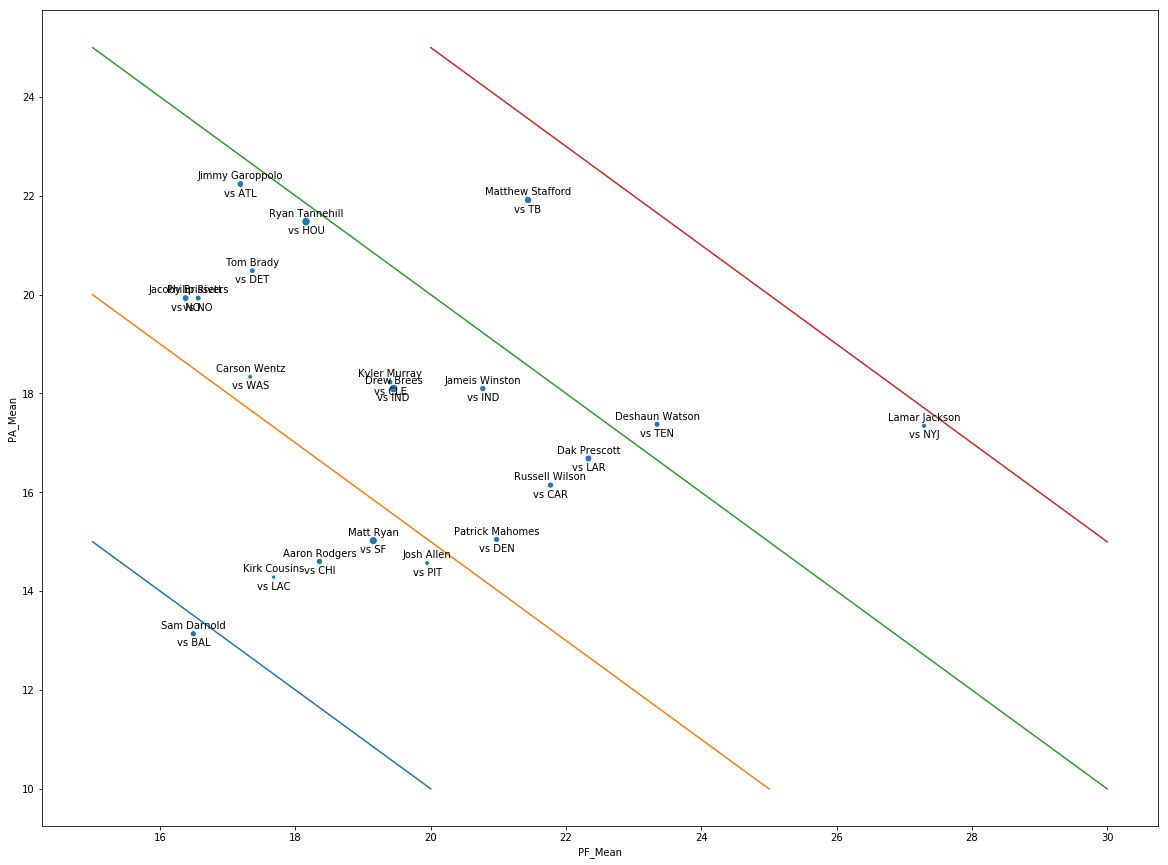

In [18]:
# Matchups for Top 10 QBs

plt.figure(figsize=(20,15))
#sns.set(style="darkgrid")

p1 = sns.scatterplot(data=qb_matchups, x="PF_Mean", y="PA_Mean", marker="o", size="Marker Size", legend=False)

for x in range(0,qb_matchups.shape[0]):
    
    # Add Player Names
    p1.text(qb_matchups.PF_Mean[x], 
        qb_matchups.PA_Mean[x]+.1, 
        qb_matchups.Player[x], 
        horizontalalignment='center', 
        size='medium')
    
    # Add Opponents
    p1.text(qb_matchups.PF_Mean[x], 
        qb_matchups.PA_Mean[x]-.25, 
        "vs "+qb_matchups.Opp[x], 
        horizontalalignment='center', 
        size='medium')

# Add Tiers
plt.plot([20,15],[10,15])
plt.plot([25,15],[10,20])
plt.plot([30,15],[10,25])
plt.plot([30,20],[15,25])

<Figure size 1440x1080 with 0 Axes>

Text(18.7692,30.7654,'Michael Thomas')

Text(18.7692,30.1154,'vs IND')

Text(16.8077,32.3115,'Chris Godwin')

Text(16.8077,31.6615,'vs DET')

Text(15.3231,32.3115,'Mike Evans')

Text(15.3231,31.6615,'vs DET')

Text(15.2154,26.2962,'DeAndre Hopkins')

Text(15.2154,25.6462,'vs CLE')

Text(14.5077,25.2192,'Julian Edelman')

Text(14.5077,24.5692,'vs CIN')

Text(14.4923,26.9115,'Amari Cooper')

Text(14.4923,26.2615,'vs LAR')

Text(14.2538,37.85,'Kenny Golladay')

Text(14.2538,37.2,'vs TB')

Text(13.9308,30.3269,'D.J. Chark')

Text(13.9308,29.6769,'vs LV')

Text(13.8385,22.7577,'Cooper Kupp')

Text(13.8385,22.1077,'vs DAL')

Text(13.3556,24.25,'Tyreek Hill')

Text(13.3556,23.6,'vs DEN')

Text(13.3167,22.9346,'Julio Jones')

Text(13.3167,22.2846,'vs SF')

Text(13.0846,28.5808,'D.J. Moore')

Text(13.0846,27.9308,'vs SEA')

Text(13.0615,25.0346,'Allen Robinson')

Text(13.0615,24.3846,'vs GB')

Text(12.9444,23.0346,'Davante Adams')

Text(12.9444,22.3846,'vs CHI')

Text(12.8692,31.6346,'Keenan Allen')

Text(12.8692,30.9846,'vs MIN')

Text(12.7308,22.9346,'Calvin Ridley')

Text(12.7308,22.2846,'vs SF')

Text(12.6923,32.2115,'Jarvis Landry')

Text(12.6923,31.5615,'vs ARI')

Text(12.5667,22.7577,'Robert Woods')

Text(12.5667,22.1077,'vs DAL')

Text(12.5308,37.85,'Marvin Jones')

Text(12.5308,37.2,'vs TB')

Text(12.5154,22.6346,'Courtland Sutton')

Text(12.5154,21.9846,'vs KC')

Text(12.3636,26.9115,'Michael Gallup')

Text(12.3636,26.2615,'vs LAR')

Text(12.1857,32.7192,'T.Y. Hilton')

Text(12.1857,32.0692,'vs NO')

Text(12.1769,26.1654,'John Brown')

Text(12.1769,25.5154,'vs PIT')

Text(12.1077,26.1654,'Stefon Diggs')

Text(12.1077,25.5154,'vs PIT')

Text(12.0308,29.9038,'Tyler Lockett')

Text(12.0308,29.2538,'vs CAR')

Text(11.8375,21.8346,'Adam Thielen')

Text(11.8375,21.1846,'vs LAC')

Text(11.7182,32.4654,'Darius Slayton')

Text(11.7182,31.8154,'vs MIA')

Text(11.6692,32.7885,'DeVante Parker')

Text(11.6692,32.1385,'vs NYG')

Text(11.51,26.2962,'Christian Kirk')

Text(11.51,25.6462,'vs CLE')

Text(11.025,32.4654,'Golden Tate')

Text(11.025,31.8154,'vs MIA')

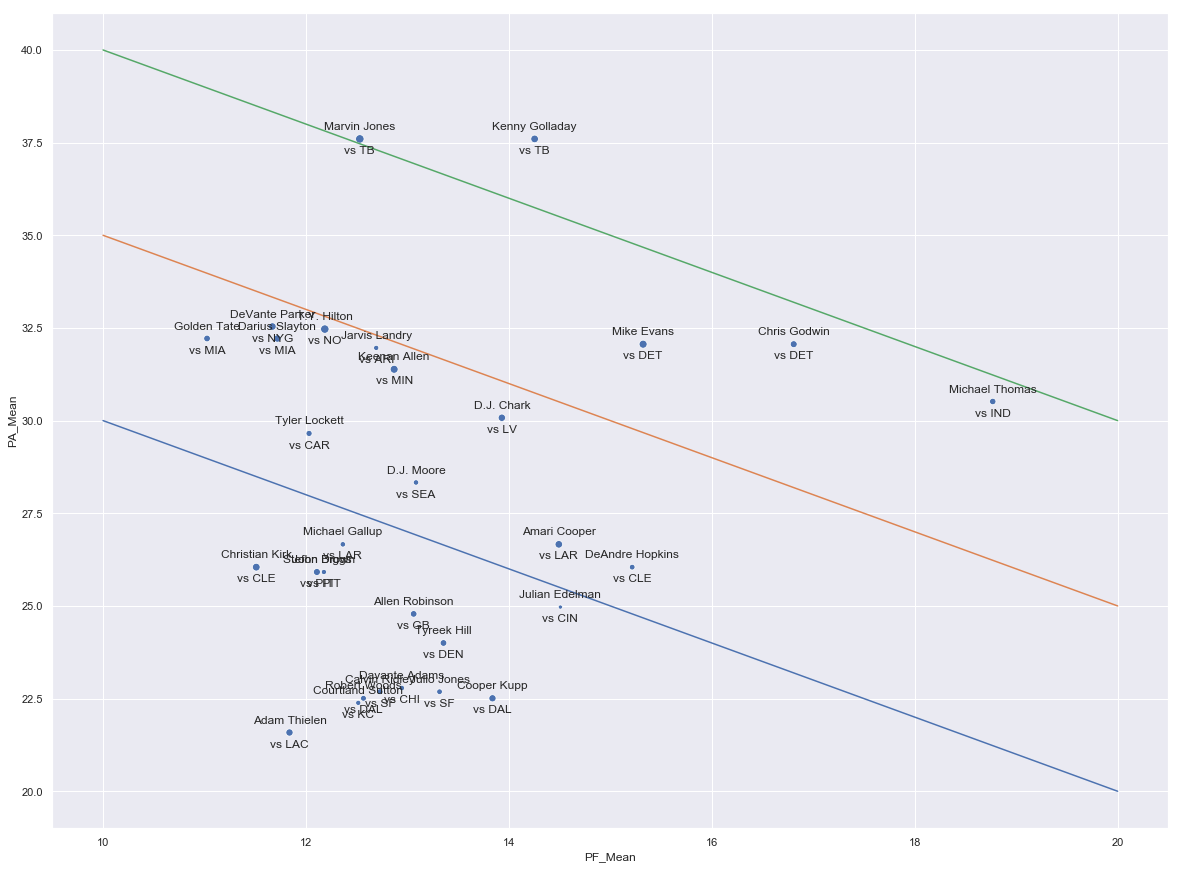

In [19]:
# Matchups for Top 20 WRs

plt.figure(figsize=(20,15))
sns.set(style="darkgrid")

p1 = sns.scatterplot(data=wr_matchups, x="PF_Mean", y="PA_Mean", marker="o", size="Marker Size", legend=False)

for x in range(0,wr_matchups.shape[0]):
    
    p1.text(wr_matchups.PF_Mean[x], 
        wr_matchups.PA_Mean[x]+.25, 
        wr_matchups.Player[x], 
        horizontalalignment='center', 
        size='medium')
    
    p1.text(wr_matchups.PF_Mean[x], 
        wr_matchups.PA_Mean[x]-.4, 
        "vs "+wr_matchups.Opp[x], 
        horizontalalignment='center', 
        size='medium')

plt.plot([20,10],[20,30])
plt.plot([20,10],[25,35])
plt.plot([20,10],[30,40])